# Evaluation of Image Quality for a Given dataID
### This notebook is meant for imaging data. Run spectral data at your own risk

In [9]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

import lsst.daf.butler as dafButler
from lsst.rapid.analysis import BestEffortIsr
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfConfig
from lsst.pex.exceptions import InvalidParameterError
from lsst.ts.observatory.control.constants import latiss_constants
from lsst.geom import PointD

%matplotlib inline

#### Declare butler repo parameters

In [10]:
datapath='/repo/LATISS'
butler = dafButler.Butler(datapath, instrument='LATISS', collections=['LATISS/raw/all','LATISS_test_data'])
dataset='raw'
best_effort_isr = BestEffortIsr(datapath)

### Select the data ID of choice

In [26]:
dataId = {'day_obs': 20220216, 'seq_num': 711, 'detector': 0, "instrument": 'LATISS'}

 ### Fetch the exposure and run best_effort_ISR

In [27]:
best_effort_isr.doWrite = False  # Don't write to butler database
exp = best_effort_isr.getExposure(dataId, skipCosmics=False)

# Calculate Stellar PSF Information

### Declare the function that does the heavy lifting using DM tools
Note that this is very sensitive to the number of sources in the field. <br>
If there are not enough sources this will fail.

In [28]:
def measurePsf(exp):
    platescale = latiss_constants.pixel_scale

    imCharConfig = CharacterizeImageTask.ConfigClass()
    imCharConfig.doMeasurePsf = True
    imCharConfig.useSimplePsf = True
    
    imCharConfig.doApCorr = False
    imCharConfig.doDeblend = False
    
    installConfig = InstallGaussianPsfConfig()
    exp.setPsf(None)  # if not set to none, fwhm max para is ignored
    installConfig.fwhm = 15
    installConfig.width = 61
    
    imCharConfig.installSimplePsf = installConfig    
    
    imCharConfig.detection.includeThresholdMultiplier = 5

    imCharConfig.measurePsf.starSelector['objectSize'].doFluxLimit = True
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMin = 12500.0
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].doSignalToNoiseLimit = False
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMin = 20.0
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMin = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMax = 80.0  # default 10
    imCharConfig.measurePsf.starSelector['objectSize'].sourceFluxField = "base_GaussianFlux_instFlux"
    imCharConfig.measurePsf.starSelector['objectSize'].widthStdAllowed = 0.15 # 0.15 default
    imCharConfig.measurePsf.starSelector['objectSize'].nSigmaClip = 2.0
    
    
    imCharConfig.background.binSize = 2000
    imCharConfig.background.approxOrderX = 2
    imCharConfig.measurePsf.psfDeterminer['psfex'].spatialOrder = 1

    imCharConfig.detection.background = imCharConfig.background
    
    imCharTask = CharacterizeImageTask(config=imCharConfig)

    result = imCharTask.run(exp)

    psf = exp.getPsf()
    ixx = psf.computeShape(exp.getBBox().getCenter()).getIxx()
    iyy = psf.computeShape(exp.getBBox().getCenter()).getIyy()
    psfShape = psf.computeShape(exp.getBBox().getCenter()).getDeterminantRadius()
    
    fwhmX = np.sqrt(ixx)*2.355*platescale
    fwhmY = np.sqrt(iyy)*2.355*platescale
    
    overallFwhm = psfShape * 2.355 * platescale
    print(f"Psf shape from imChar task (x,y) = ({fwhmX:.3f}, {fwhmY:.3f}) FWHM arcsec")
    return fwhmX, fwhmY, overallFwhm, psf

#### Declare QuickFrameMeasurement tasks
These are run if the measurePsf method fails. It provides a reasonable yet less-accurate representation.

In [29]:
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

### Run the methods to get the psf data

In [30]:
brightest_source_centroid = []
fwhmX=None; fwhmY=None; overallFwhm=None
result=None
psf=None
success=False
try:
    fwhmX, fwhmY, overallFwhm, psf = measurePsf(exp)
    success=True
    pass
except InvalidParameterError as e:
    print('Caught the InvalidParameterError, measurePsf was not successful')
    #print(f'error is {e}')
    pass
except RuntimeError as e:
    print('Caught the RuntimeError, measurePsf was not successful')
    #print(f'error is {e}')
    pass

if not success:
    print('Using Merlin\'s simplified algorithm')
    result = qm.run(exp)
    brightest_source_centroid.append(result)
    if result.success:
        fwhmX=result.medianXxYy[0]
        fwhmY=result.medianXxYy[1]
        overallFwhm=np.sqrt(result.medianXxYy[0]**2 + result.medianXxYy[1]**2)
    else:
        raise RuntimeError('No PSF could be derived using either method')

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+2fe588fcc2/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Psf shape from imChar task (x,y) = (1.324, 1.279) FWHM arcsec


#### Derive Corrections for elevation (airmass) and wavelength

Capture metadata for calculation and comparison

In [31]:
filter_band=exp.getInfo().getFilterLabel().bandLabel 
airmass=((exp.getInfo().getMetadata().get('AMSTART')+exp.getInfo().getMetadata().get('AMEND'))/2.0)
elevation=((exp.getInfo().getMetadata().get('ELSTART')+exp.getInfo().getMetadata().get('ELEND'))/2.0)
dimm_seeing=exp.getInfo().getMetadata().get('SEEING')

In [32]:
print(f"Target at elevation = {elevation:0.1f}, airmass = {airmass:0.1f}")
print(f"PSF shape from imChar task (x,y) = ({fwhmX:.2f}, {fwhmY:.2f}) FWHM [arcsec]")
print(f"Overall PSF shape from imChar task is = {overallFwhm:.2f} FWHM [arcsec]")

Target at elevation = 34.3, airmass = 1.8
PSF shape from imChar task (x,y) = (1.32, 1.28) FWHM [arcsec]
Overall PSF shape from imChar task is = 1.30 FWHM [arcsec]


Calculate airmass corrected FWHM

In [33]:
airmass_corr_fwhm = overallFwhm * (airmass ** -0.6)

Filter wavelengths are not currently in the fits headers.
Must use an ugly dictionary until this is implemented.

In [34]:
filter_wavelength= {'white': 700, 'g': 475, 'r': 623, 'i': 763, 'z': 828.0}

#### Derive airmass+wavelength corrected FWHM

In [35]:
corr_fwhm = airmass_corr_fwhm * ((500. / filter_wavelength[filter_band]) ** -0.2)
print(f'Airmass and wavelength corrected FWHM: {corr_fwhm:0.3f} [arcsec]')
print(f'DIMM reported FWHM: {dimm_seeing:0.3f} [arcsec]')

Airmass and wavelength corrected FWHM: 0.984 [arcsec]
DIMM reported FWHM: 1.579 [arcsec]


### Display PSF
This will only work if the measurePSF was successful

In [36]:
# Create a normalized PSF array for display
z=psf.computeImage(position=psf.getAveragePosition()).array/psf.computePeak(position=psf.getAveragePosition())

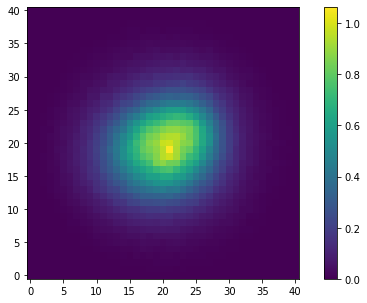

In [37]:
plt.figure(figsize=(9, 5))
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.colorbar()
plt.show()